In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random as rd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from copy import deepcopy
from tqdm import tqdm
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
from zipfile import ZipFile
import os


def join_split_zip_files(split_zip_files_directory: str, destination_dir: str = './temp/', zip_filename: str = 'temp.zip') -> None:
    split_zip_files = os.listdir(split_zip_files_directory)
    zip_filepath = os.path.join(destination_dir, zip_filename)
    if os.path.isfile(zip_filepath):
        os.remove(zip_filepath)
    for split_zip_file in split_zip_files:
        with open(zip_filepath, "ab") as zip_file:
            with open(os.path.join(split_zip_files_directory, split_zip_file), "rb") as split_zip:
                zip_file.write(split_zip.read())
    return zip_filepath


def unzip_file(zip_filepath: str, destination_dir: str) -> None:
    with ZipFile(zip_filepath, 'r') as zipfile:
        zipfile.extractall(destination_dir)


def unzip_required_asset(filepath: str, zip_path: str, destination_dir: str) -> None:
    if not os.path.isfile(filepath):
        if os.path.isfile(zip_path):
            unzip_file(zip_path, destination_dir)
        elif os.path.isdir(zip_path):
            zip_filepath = join_split_zip_files(zip_path, destination_dir)
            unzip_file(zip_filepath, destination_dir)
            os.remove(zip_filepath)


In [3]:
shortlist_coutries = ['Argentina', 'Brazil', 'Canada', 
       'France', 'Germany', 'Ireland', 'Italy', 
       'Mexico', 'Spain',  
       'United Kingdom of Great Britain and Northern Ireland','United States of America']

continents = ['Africa', 'Americas', 'Asia',
      'Europe', 'Oceania']

cont_region = ['Eastern Africa',
       'Middle Africa', 'Northern Africa', 'Southern Africa',
       'Western Africa', 'Northern America',
       'Central America', 'Caribbean', 'South America', 
       'Central Asia', 'Eastern Asia', 'Southern Asia',
       'South-eastern Asia', 'Western Asia', 'Eastern Europe',
       'Northern Europe', 'Southern Europe', 'Western Europe', 'Oceania']

# Value of Production

In [4]:
vp_beef = ['Milk, whole fresh cow', 'Meat, cattle']

In [5]:
filepath = './../temp/value-of-production.csv'
zip_filepath = './../assets/value-of-production.zip'
temp_directory= './../temp'
unzip_required_asset(filepath, zip_filepath, temp_directory)

vp = pd.read_csv(filepath, encoding='latin1')
vp = vp.drop(['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag'], axis=1)
vp = vp.loc[vp.Area.isin(shortlist_coutries)]
vp = vp.loc[vp.Item.isin(vp_beef)]
vp = vp.sort_values(by=["Area","Item", "Year"])
vp.reset_index(inplace=True,drop=True)
vp.sample(5)
#SLC standing for Standard Local Currency will require conversion.

,Area,Item,Element,Year,Unit,Value
1250,France,"Meat, cattle",Gross Production Value (constant 2014-2016 tho...,1972,1000 US$,6716831.0
3783,United Kingdom of Great Britain and Northern I...,"Meat, cattle",Gross Production Value (current thousand US$),1999,1000 US$,2542356.0
3464,Spain,"Milk, whole fresh cow",Gross Production Value (constant 2014-2016 tho...,1964,1000 SLC,1033205.0
3301,Spain,"Meat, cattle",Gross Production Value (constant 2014-2016 tho...,1972,1000 US$,834550.0
1949,Germany,"Milk, whole fresh cow",Gross Production Value (constant 2014-2016 tho...,2000,1000 Int. $,11790079.0


# Trade:

## Imports by Value and Quantity & Exports by Value and Quantity

In [6]:
trade_cl_beef = ['Meat, cattle','Butter, cow milk','Milk, whole fresh cow']

In [7]:
filepath = './../temp/trade-crops-livestock.csv'
zip_filepath = './../assets/trade-crops-livestock/'
temp_directory= './../temp'
unzip_required_asset(filepath, zip_filepath, temp_directory)

trade_cl = pd.read_csv(filepath,encoding="latin1")
#trade_cl = trade_cl.loc[trade_cl.Year >= 1990]
trade_cl = trade_cl.drop(['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag'], axis=1)
trade_cl = trade_cl.loc[trade_cl.Area.isin(shortlist_coutries)]
trade_cl = trade_cl.loc[trade_cl.Item.isin(trade_cl_beef)]
trade_cl = trade_cl.sort_values(by=["Area","Item", "Year"])
trade_cl.reset_index(inplace=True,drop=True)
trade_cl.sample(5)

,Area,Item,Element,Year,Unit,Value
2467,France,"Meat, cattle",Import Value,1980,1000 US$,814262.0
7162,United Kingdom of Great Britain and Northern I...,"Milk, whole fresh cow",Export Quantity,2014,tonnes,601319.0
2751,France,"Milk, whole fresh cow",Import Value,1991,1000 US$,100483.0
1786,Canada,"Meat, cattle",Import Quantity,1990,tonnes,20956.0
996,Brazil,"Meat, cattle",Export Quantity,1972,tonnes,155627.0


In [8]:
#Splitting datasets into value and wuantity, unity of measure for Quant. in tonnes and for Value uses per 1000 U$
trade_cl_quantity = trade_cl.loc[(trade_cl.Element == "Export Quantity")|(trade_cl.Element == "Import Quantity")]
trade_cl_value = trade_cl.loc[(trade_cl.Element == "Export Value")|(trade_cl.Element == "Import Value")]
trade_cl_quantity.reset_index(inplace=True,drop=True)
trade_cl_value.reset_index(inplace=True,drop=True)

In [9]:
years = range(1961,2021) #Year to analyse

In [10]:
#Creation of missing years to quantity
for c in trade_cl_quantity.Area.unique():
  country = trade_cl_quantity.loc[trade_cl_quantity.Area == c]
  country.reset_index(inplace=True,drop=True)
  for item in country.Item.unique():
    for year in years:
      country_fitered = country.loc[(country.Year == year) & (country.Item == item)]
      country_filt_import = country_fitered.loc[country_fitered.Element == "Import Quantity"]
      country_filt_import.reset_index(inplace=True,drop=True)
      if len(country_filt_import) < 1:
        series = country.loc[0]
        series["Item"] = item
        series["Element"] = "Import Quantity"
        series["Year"] = year
        series["Value"] = np.nan
        trade_cl_quantity=trade_cl_quantity.append(series)
      
      country_filt_export = country_fitered.loc[country_fitered.Element == "Export Quantity"]
      country_filt_export.reset_index(inplace=True,drop=True)
      if len(country_filt_export) < 1:
        series = country.loc[0]
        series["Item"] = item
        series["Element"] = "Export Quantity"
        series["Year"] = year
        series["Value"] = np.nan
        trade_cl_quantity=trade_cl_quantity.append(series)

In [11]:
#Understand the percentage of missing data per Area
for c in trade_cl_quantity.Area.unique():
  total = trade_cl_quantity.loc[trade_cl_quantity.Area == c].shape[0]
  n = trade_cl_quantity.loc[(trade_cl_quantity.Value.isnull()) & (trade_cl_quantity.Area == c)]
  nulls = n.shape[0]
  print("Percentage total of null for country {0} is {1}".format(c,round((nulls/total)*100,2)))
  print("\nMissing items:",n.Item.value_counts())
  print("\n\n")


Percentage total of null for country Argentina is 1.39

Missing items: Meat, cattle             3
Butter, cow milk         1
Milk, whole fresh cow    1
Name: Item, dtype: int64



Percentage total of null for country Brazil is 0.0

Missing items: Series([], Name: Item, dtype: int64)



Percentage total of null for country Canada is 0.0

Missing items: Series([], Name: Item, dtype: int64)



Percentage total of null for country France is 0.0

Missing items: Series([], Name: Item, dtype: int64)



Percentage total of null for country Germany is 0.0

Missing items: Series([], Name: Item, dtype: int64)



Percentage total of null for country Ireland is 0.0

Missing items: Series([], Name: Item, dtype: int64)



Percentage total of null for country Italy is 0.0

Missing items: Series([], Name: Item, dtype: int64)



Percentage total of null for country Mexico is 0.28

Missing items: Butter, cow milk    1
Name: Item, dtype: int64



Percentage total of null for country Spain is 0.0

Missing 

In [12]:
#Creation of missing years to Value
for c in trade_cl_value.Area.unique():
  country = trade_cl_value.loc[trade_cl_value.Area == c] #Filter by country
  country.reset_index(inplace=True,drop=True) #Reset Index
  for item in country.Item.unique():
    for year in years:
      country_fitered = country.loc[(country.Year == year) & (country.Item == item)]
      country_filt_import = country_fitered.loc[country_fitered.Element == "Import Value"]
      country_filt_import.reset_index(inplace=True,drop=True)
      if len(country_filt_import) < 1:
        series = country.loc[0]
        series["Item"] = item
        series["Element"] = "Import Value"
        series["Year"] = year
        series["Value"] = np.nan
        trade_cl_value=trade_cl_value.append(series)
      
      country_filt_export = country_fitered.loc[country_fitered.Element == "Export Value"]
      country_filt_export.reset_index(inplace=True,drop=True)
      if len(country_filt_export) < 1:
        series = country.loc[0]
        series["Item"] = item
        series["Element"] = "Export Value"
        series["Year"] = year
        series["Value"] = np.nan
        trade_cl_value=trade_cl_value.append(series)


In [13]:
#Understand the percentage of missing data per Area
for c in trade_cl_value.Area.unique():
  total = trade_cl_value.loc[trade_cl_value.Area == c].shape[0]
  n = trade_cl_value.loc[(trade_cl_value.Value.isnull()) & (trade_cl_value.Area == c)]
  nulls = n.shape[0]
  print("Percentage total of null for country {0} is {1}".format(c,round((nulls/total)*100,2)))
  print("\nMissing items:",n.Item.value_counts())
  print("\n\n")

Percentage total of null for country Argentina is 1.39

Missing items: Meat, cattle             3
Butter, cow milk         1
Milk, whole fresh cow    1
Name: Item, dtype: int64



Percentage total of null for country Brazil is 0.0

Missing items: Series([], Name: Item, dtype: int64)



Percentage total of null for country Canada is 0.0

Missing items: Series([], Name: Item, dtype: int64)



Percentage total of null for country France is 0.0

Missing items: Series([], Name: Item, dtype: int64)



Percentage total of null for country Germany is 0.0

Missing items: Series([], Name: Item, dtype: int64)



Percentage total of null for country Ireland is 0.0

Missing items: Series([], Name: Item, dtype: int64)



Percentage total of null for country Italy is 0.0

Missing items: Series([], Name: Item, dtype: int64)



Percentage total of null for country Mexico is 0.28

Missing items: Butter, cow milk    1
Name: Item, dtype: int64



Percentage total of null for country Spain is 0.0

Missing 

In [14]:
trade_cl_qt_filled = pd.DataFrame(columns=trade_cl_quantity.columns)
for c in trade_cl_quantity.Area.unique():
  for item in trade_cl_quantity.Item.unique():
    for element in trade_cl_quantity.Element.unique():
      country = trade_cl_quantity.loc[(trade_cl_quantity.Area == c)&(trade_cl_quantity.Item == item)& (trade_cl_quantity.Element == element )]
      country = country.sort_values(by="Year")#.interpolate()
      mean = round(country.Value.mean()) #Fill with mean
      country = country.fillna(mean)
      trade_cl_qt_filled = trade_cl_qt_filled.append(country)
      trade_cl_qt_filled.reset_index(drop=True,inplace=True)



In [15]:
trade_cl_vl_filled = pd.DataFrame(columns=trade_cl_value.columns)
for c in trade_cl_value.Area.unique():
  for item in trade_cl_value.Item.unique():
    for element in trade_cl_value.Element.unique():
      country = trade_cl_value.loc[(trade_cl_value.Area == c)&(trade_cl_value.Item == item)& (trade_cl_value.Element == element )]
      country = country.sort_values(by="Year")#.interpolate()
      mean = round(country.Value.mean()) #Fill with mean
      country = country.fillna(mean)
      trade_cl_vl_filled = trade_cl_vl_filled.append(country)
      trade_cl_vl_filled.reset_index(drop=True,inplace=True)



In [ ]:
population = pd.read_excel("Population Sample Data.xlsx")
population.columns = ["COUNTRY","POPULATION NO.","POP per 1000"]
dic = {}
for i in range(len(population)):
  dic.update({
      population.COUNTRY[i]:population["POPULATION NO."][i]
  })
dic

In [ ]:
#Value in dolars
trade_cl_vl_filled["Total_value"] = trade_cl_vl_filled.Value * 1000
trade_cl_vl_filled.tail()

#Add population
pop = []
for i in range(len(trade_cl_vl_filled)):
  pop.append(int(dic[trade_cl_vl_filled.Area[i]].replace(",","")))
trade_cl_vl_filled["Population"] = pop

#Calculate Per Capita
trade_cl_vl_filled["Per Capita"] = trade_cl_vl_filled.Total_value / trade_cl_vl_filled.Population
trade_cl_vl_filled["Per Capita"] = trade_cl_vl_filled["Per Capita"].round(3)

In [ ]:
for element in trade_cl_vl_filled.Element.unique():
  for item in trade_cl_vl_filled.Item.unique():
    #Filter by Trade Type and Product Type
    imp = trade_cl_vl_filled.loc[(trade_cl_vl_filled.Element == element)&(trade_cl_vl_filled.Item == item)]
    imp.reset_index(inplace=True,drop=True)
    sns.set(rc = {'figure.figsize':(25,12)}) #Set figure size

    #Plot
    sns.lineplot(x='Year', y='Per Capita',hue="Area",
                data=imp[["Area","Year","Per Capita"]], color="red" ).set_title("{0} -  {1}".format(element,item)) #Plot
    plt.show()

In [ ]:
#Value in dolars
trade_cl_qt_filled["Total_value"] = trade_cl_qt_filled.Value * 1000
trade_cl_qt_filled.tail()

#Add population
pop = []
for i in range(len(trade_cl_qt_filled)):
  pop.append(int(dic[trade_cl_qt_filled.Area[i]].replace(",","")))
trade_cl_qt_filled["Population"] = pop

#Calculate Per Capita
trade_cl_qt_filled["Per Capita"] = trade_cl_qt_filled.Total_value / trade_cl_qt_filled.Population
trade_cl_qt_filled["Per Capita"] = trade_cl_qt_filled["Per Capita"].round(3)
trade_cl_qt_filled.head()

In [ ]:
for element in trade_cl_qt_filled.Element.unique():
  for item in trade_cl_qt_filled.Item.unique():
    #Filter by Trade Type and Product Type
    imp = trade_cl_qt_filled.loc[(trade_cl_qt_filled.Element == element)&(trade_cl_qt_filled.Item == item)]
    imp.reset_index(inplace=True,drop=True)
    sns.set(rc = {'figure.figsize':(25,12)}) #Set figure size

    #Plot
    sns.lineplot(x='Year', y='Per Capita',hue="Area",
                data=imp[["Area","Year","Per Capita"]], color="red" ).set_title("{0} -  {1}".format(element,item)) #Plot
    plt.show()

# Supply Utilization Accounts - Crops & Livestock

In [17]:
sua_beef = ['Meat, cattle']

"""sua_beef = ['Beef and Buffalo Meat', 'Beef Mutton Pigmeat Prim''Meat, beef and veal sausages',
       'Meat, beef, dried, salted, smoked', 'Meat, beef, preparations', 'Meat, cattle',
       'Meat, cattle, boneless (beef & veal)', 'Beef and Buffalo Meat', 'Beef Mutton Pigmeat Prim']"""

"sua_beef = ['Beef and Buffalo Meat', 'Beef Mutton Pigmeat Prim''Meat, beef and veal sausages',\n       'Meat, beef, dried, salted, smoked', 'Meat, beef, preparations', 'Meat, cattle',\n       'Meat, cattle, boneless (beef & veal)', 'Beef and Buffalo Meat', 'Beef Mutton Pigmeat Prim']"

In [18]:
filepath = './../temp/sua-crops-livestock.csv'
zip_filepath = './../assets/sua-crops-livestock.zip'
temp_directory= './../temp'
unzip_required_asset(filepath, zip_filepath, temp_directory)

sua = pd.read_csv(filepath, encoding='latin1')
#sua = sua.drop(['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag'], axis=1)
sua = sua.loc[sua.Area.isin(shortlist_coutries)]
sua = sua.loc[sua.Item.isin(sua_beef)]
sua = sua.sort_values(by=["Area","Item", "Year"])
sua.reset_index(inplace=True,drop=True)
sua

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,9,Argentina,867,"Meat, cattle",5113,Opening stocks,2010,2010,tonnes,563579.0,F
1,9,Argentina,867,"Meat, cattle",5510,Production,2010,2010,tonnes,2630163.0,NaN
2,9,Argentina,867,"Meat, cattle",5610,Import Quantity,2010,2010,tonnes,1722.0,NaN
3,9,Argentina,867,"Meat, cattle",5071,Stock Variation,2010,2010,tonnes,0.0,F
4,9,Argentina,867,"Meat, cattle",5910,Export Quantity,2010,2010,tonnes,2600.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1302,231,United States of America,867,"Meat, cattle",5910,Export Quantity,2019,2019,tonnes,130431.0,NaN
1303,231,United States of America,867,"Meat, cattle",5016,Loss,2019,2019,tonnes,0.0,Im
1304,231,United States of America,867,"Meat, cattle",5023,Processed,2019,2019,tonnes,12344283.0,Im
1305,231,United States of America,867,"Meat, cattle",5165,Other uses (non-food),2019,2019,tonnes,0.0,F


In [19]:
categories = ['Production', 'Import Quantity', 'Export Quantity']
sua_prod_imp_exp = sua.loc[sua.Element.isin(categories)]
sua_prod_imp_exp.reset_index(inplace=True,drop=True)

In [20]:
sua_prod_imp_exp.Item.unique()

array(['Meat, cattle'], dtype=object)

In [21]:
sua_filled_df = pd.DataFrame(columns=sua_prod_imp_exp.columns)

for country in tqdm(list(sua_prod_imp_exp.Area.unique())):
  for type_of_meat in list(sua_prod_imp_exp.Item.unique()):
    for element in list(sua_prod_imp_exp.Element.unique()):
      temp_df = sua_prod_imp_exp.loc[(sua_prod_imp_exp.Area == country) & (sua_prod_imp_exp.Item == type_of_meat ) & (sua_prod_imp_exp.Element == element)]
      temp_df.fillna(temp_df.Value.mean(),inplace=True)
      sua_filled_df = sua_filled_df.append(temp_df)
      sua_filled_df.reset_index(inplace=True,drop=True)

sua_filled_df.dropna(inplace=True)
sua_filled_df.isnull().sum()
sua_filled_df.reset_index(inplace=True,drop=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 48.89it/s]


In [22]:
sua_filled_df

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,9,Argentina,867,"Meat, cattle",5510,Production,2010,2010,tonnes,2630163.0,2763805.3
1,9,Argentina,867,"Meat, cattle",5510,Production,2011,2011,tonnes,2498954.0,2763805.3
2,9,Argentina,867,"Meat, cattle",5510,Production,2012,2012,tonnes,2595815.0,2763805.3
3,9,Argentina,867,"Meat, cattle",5510,Production,2013,2013,tonnes,2821608.0,2763805.3
4,9,Argentina,867,"Meat, cattle",5510,Production,2014,2014,tonnes,2674000.0,2763805.3
...,...,...,...,...,...,...,...,...,...,...,...
322,231,United States of America,867,"Meat, cattle",5910,Export Quantity,2015,2015,tonnes,111415.0,117609.4
323,231,United States of America,867,"Meat, cattle",5910,Export Quantity,2016,2016,tonnes,119348.0,117609.4
324,231,United States of America,867,"Meat, cattle",5910,Export Quantity,2017,2017,tonnes,128586.0,117609.4
325,231,United States of America,867,"Meat, cattle",5910,Export Quantity,2018,2018,tonnes,137348.0,117609.4


In [23]:
sua_filled_df["1000 Tonnes"] = sua_filled_df["Value"] / 1000
sua_filled_df 

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,1000 Tonnes
0,9,Argentina,867,"Meat, cattle",5510,Production,2010,2010,tonnes,2630163.0,2763805.3,2630.163
1,9,Argentina,867,"Meat, cattle",5510,Production,2011,2011,tonnes,2498954.0,2763805.3,2498.954
2,9,Argentina,867,"Meat, cattle",5510,Production,2012,2012,tonnes,2595815.0,2763805.3,2595.815
3,9,Argentina,867,"Meat, cattle",5510,Production,2013,2013,tonnes,2821608.0,2763805.3,2821.608
4,9,Argentina,867,"Meat, cattle",5510,Production,2014,2014,tonnes,2674000.0,2763805.3,2674.000
...,...,...,...,...,...,...,...,...,...,...,...,...
322,231,United States of America,867,"Meat, cattle",5910,Export Quantity,2015,2015,tonnes,111415.0,117609.4,111.415
323,231,United States of America,867,"Meat, cattle",5910,Export Quantity,2016,2016,tonnes,119348.0,117609.4,119.348
324,231,United States of America,867,"Meat, cattle",5910,Export Quantity,2017,2017,tonnes,128586.0,117609.4,128.586
325,231,United States of America,867,"Meat, cattle",5910,Export Quantity,2018,2018,tonnes,137348.0,117609.4,137.348


In [26]:
"""def create_df(df):
  temp_df = pd.DataFrame()
  temp_df["Production"] = df.loc[df.Element == "Production"]["1000 Tonnes"]
  temp_df["Export Quantity"] = df.loc[df.Element == "Export Quantity"]["1000 Tonnes"]
  temp_df["Import Quantity"] = df.loc[df.Element == "Import Quantity"]["1000 Tonnes"]
  temp_df.insert(0,"Year",list(df.Year.unique()))
"""

def plot(df,region):
  
  df = df.loc[df.Area == region]
  df.reset_index(inplace=True,drop=True)
  sns.set(rc = {'figure.figsize':(25,12)}) #Set figure size
  temp_df = create_df()

  print(temp_df.head())

  sns.lineplot(x='Year', y='value', hue='variable',
             data=pd.melt(temp_df, ['Year'])).set_title("Region: {0} - Trade: {1} (Thousand Tonnes).".format(region))
  plt.show()

In [30]:
"""plot(sua_filled_df,"Argentina")"""

'plot(sua_filled_df,"Argentina")'

In [25]:
def plot(df,region,meat_type="Meat, Cattle"):
  df = df.loc[df.Area == region]
  df.reset_index(inplace=True,drop=True)
  sns.set(rc = {'figure.figsize':(25,12)}) #Set figure size
  for element in df.Element.unique():
    sns.lineplot(x='Year', y='1000 Tonnes', data=df[["Year","1000 Tonnes"]]).set_title("Region: {0} - Trade: {1} (Thousand Tonnes).".format(region,meat_type)) #Plot
  #plt.savefig("images/"+ region +'.png')
  plt.show()

In [27]:
for region in sua_filled_df.Area.unique():
  plot(sua_filled_df,region)

NameError: name 'create_df' is not defined

In [28]:
len(sua_filled_df.Element.unique()) * len(sua_filled_df.Area.unique())

33

In [29]:
#Distribution of Elements by Year by Region by item

In [30]:
sua.Item.unique()

array(['Meat, cattle'], dtype=object)

In [31]:
sua.Element.unique()
#'Production', 'Import Quantity', 'Export Quantity'
#'Food supply (kcal/capita/day)', 'Food supply quantity (g/capita/day)', 'Protein supply quantity (g/capita/day)', 'Fat supply quantity (g/capita/day)'

array(['Opening stocks', 'Production', 'Import Quantity',
       'Stock Variation', 'Export Quantity', 'Loss', 'Processed',
       'Tourist consumption', 'Residuals',
       'Food supply quantity (tonnes)', 'Food supply (kcal/capita/day)',
       'Food supply quantity (g/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)', 'Calories/Year',
       'Proteins/Year', 'Fats/Year', 'Other uses (non-food)'],
      dtype=object)

In [32]:
sua.isnull().sum()

Area Code         0
Area              0
Item Code         0
Item              0
Element Code      0
Element           0
Year Code         0
Year              0
Unit              0
Value           106
Flag            418
dtype: int64

# Soil Nutrient (STOP)

In [33]:
nutrientflow = ['Cropland nutrient flow']

In [40]:
env_soil_nut = pd.read_csv("Environment_Soil_nutrient_budget.csv", encoding='latin1')
env_soil_nut = env_soil_nut.drop(['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag'], axis=1)
env_soil_nut = env_soil_nut.loc[env_soil_nut.Area.isin(shortlist_coutries)]
env_soil_nut = env_soil_nut.sort_values(by=["Area","Item", "Year"])
env_soil_nut.reset_index(inplace=True,drop=True)

#Unities according to Element
#Cropland nutrient flow per unit area: kg/ha
#Cropland nutrient flow: tonnes

FileNotFoundError: [Errno 2] No such file or directory: 'Environment_Soil_nutrient_budget.csv'

# Foreign Investiment

In [290]:
fi_item = ['FDI inflows to Agriculture, Forestry and Fishing',
       'Total FDI inflows', 'Total FDI outflows',
       'FDI outflows to Agriculture, Forestry and Fishing']

fi = pd.read_csv('Investment_ForeignDirectInvestment_E_All_Data.csv', encoding='Latin1')
fi = fi.loc[fi.Item.isin(fi_item)]
fi = fi.loc[fi.Area.isin(shortlist_coutries)]
fi = fi.drop(['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag'], axis=1)
fi

,Area,Item,Element,Year,Unit,Value,Note
558,Argentina,"FDI inflows to Agriculture, Forestry and Fishing",Value US$,2005,millions,284.799990,UNCTAD
559,Argentina,"FDI inflows to Agriculture, Forestry and Fishing",Value US$,2006,millions,278.600000,INTRACEN UNCTAD
560,Argentina,"FDI inflows to Agriculture, Forestry and Fishing",Value US$,2007,millions,303.460000,INTRACEN UNCTAD
561,Argentina,"FDI inflows to Agriculture, Forestry and Fishing",Value US$,2008,millions,464.850000,INTRACEN UNCTAD
562,Argentina,"FDI inflows to Agriculture, Forestry and Fishing",Value US$,2009,millions,117.290000,INTRACEN UNCTAD
...,...,...,...,...,...,...,...
27921,United States of America,Total FDI outflows,"Value US$, 2015 prices",2014,millions,336481.813193,OECD UNCTAD
27922,United States of America,Total FDI outflows,"Value US$, 2015 prices",2015,millions,264359.000000,OECD UNCTAD
27923,United States of America,Total FDI outflows,"Value US$, 2015 prices",2016,millions,286297.029779,OECD UNCTAD
27924,United States of America,Total FDI outflows,"Value US$, 2015 prices",2017,millions,291803.645673,OECD UNCTAD


# Government Expenditure

In [291]:
ge_item = ['Total Expenditure (General Government)',
       'Total Expenditure (Central Government)',
       'Agriculture (General Government)',
       'Agriculture (Central Government)']

ge = pd.read_csv('Investment_GovernmentExpenditure_E_All_Data_(Normalized).csv', encoding='latin1')
ge = ge.loc[ge.Area.isin(shortlist_coutries)]
ge = ge.loc[ge.Item.isin(ge_item)]
ge = ge.drop(['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag'], axis=1)
ge.reset_index(inplace=True,drop=True)
ge

,Area,Item,Element,Year,Unit,Value,Note
0,Argentina,Total Expenditure (General Government),Value Local Currency,2001,millions,8.506400e+04,Consolidated General Government Expenditure
1,Argentina,Total Expenditure (General Government),Value Local Currency,2002,millions,8.001000e+04,Consolidated General Government Expenditure
2,Argentina,Total Expenditure (General Government),Value Local Currency,2003,millions,9.700700e+04,Consolidated General Government Expenditure
3,Argentina,Total Expenditure (General Government),Value Local Currency,2004,millions,1.134430e+05,Consolidated General Government Expenditure
4,Argentina,Total Expenditure (General Government),Value Local Currency,2005,millions,1.500470e+05,Consolidated General Government Expenditure
...,...,...,...,...,...,...,...
1267,United States of America,Total Expenditure (Central Government),"Value US$, 2015 prices",2015,millions,2.397500e+06,Budgetary Central Government Expenditure
1268,United States of America,Total Expenditure (Central Government),"Value US$, 2015 prices",2016,millions,2.465833e+06,Budgetary Central Government Expenditure
1269,United States of America,Total Expenditure (Central Government),"Value US$, 2015 prices",2017,millions,2.495896e+06,Budgetary Central Government Expenditure
1270,United States of America,Total Expenditure (Central Government),"Value US$, 2015 prices",2018,millions,2.590376e+06,Budgetary Central Government Expenditure


# Country's Investment

In [292]:
country_invest = pd.read_csv('Investment_CountryInvestmentStatisticsProfile_E_All_Data.csv', encoding='latin1')
#country_invest = country_invest.loc[country_invest.Item.isin(prod_item)]
country_invest = country_invest.loc[country_invest.Area.isin(shortlist_coutries)]
country_invest = country_invest.drop(['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag', 'Note'], axis=1)
country_invest.reset_index(inplace=True,drop=True)
country_invest

,Area,Item,Element,Year,Unit,Value
0,Argentina,"Value Added (Agriculture, Forestry and Fishing)",Value US$,2001,millions,11539.020901
1,Argentina,"Value Added (Agriculture, Forestry and Fishing)",Value US$,2002,millions,9785.165908
2,Argentina,"Value Added (Agriculture, Forestry and Fishing)",Value US$,2003,millions,12575.393801
3,Argentina,"Value Added (Agriculture, Forestry and Fishing)",Value US$,2004,millions,13867.531258
4,Argentina,"Value Added (Agriculture, Forestry and Fishing)",Value US$,2005,millions,15926.903947
...,...,...,...,...,...,...
3682,United States of America,Gross Fixed Capital Formation as a share of Va...,"Ratio, 2010 prices",2012,NaN,0.450000
3683,United States of America,Gross Fixed Capital Formation as a share of Va...,"Ratio, 2010 prices",2013,NaN,0.420000
3684,United States of America,Gross Fixed Capital Formation as a share of Va...,"Ratio, 2010 prices",2014,NaN,0.470000
3685,United States of America,Gross Fixed Capital Formation as a share of Va...,"Ratio, 2010 prices",2015,NaN,0.340000


# Land Use

In [293]:
land_use_item = ['Country area', 'Land area', 'Agriculture']

land_use = pd.read_csv('Inputs_LandUse_E_All_Data.csv', encoding='latin1')
land_use = land_use.loc[land_use.Item.isin(land_use_item)]
land_use = land_use.loc[land_use.Area.isin(shortlist_coutries)]
land_use = land_use.drop(['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag'], axis=1)
land_use.reset_index(inplace=True,drop=True)
land_use

,Area,Item,Element,Year,Unit,Value
0,Argentina,Country area,Area,1961,1000 ha,278040.0000
1,Argentina,Country area,Area,1962,1000 ha,278040.0000
2,Argentina,Country area,Area,1963,1000 ha,278040.0000
3,Argentina,Country area,Area,1964,1000 ha,278040.0000
4,Argentina,Country area,Area,1965,1000 ha,278040.0000
...,...,...,...,...,...,...
1942,United States of America,Agriculture,Area,2015,1000 ha,404718.7000
1943,United States of America,Agriculture,Area,2016,1000 ha,405264.6000
1944,United States of America,Agriculture,Area,2017,1000 ha,405810.3538
1945,United States of America,Agriculture,Area,2018,1000 ha,405810.3538


# Production

In [34]:
prod_item = ['Meat, cattle', 'Milk, whole fresh cow', 'Butter, cow milk']

filepath = './../temp/production-crops-livestock-e-all-data.csv'
zip_filepath = './../assets/production-crops-livestock-e-all-data.zip'
temp_directory= './../temp'
unzip_required_asset(filepath, zip_filepath, temp_directory)

prod = pd.read_csv(filepath, encoding='latin1')
prod = prod.loc[prod.Item.isin(prod_item)]
prod = prod.loc[prod.Area.isin(shortlist_coutries)]
prod = prod.drop(['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag'], axis=1)
prod.reset_index(inplace=True,drop=True)
prod

,Area,Item,Element,Year,Unit,Value
0,Argentina,"Butter, cow milk",Production,1961,tonnes,54674.0
1,Argentina,"Butter, cow milk",Production,1962,tonnes,49011.0
2,Argentina,"Butter, cow milk",Production,1963,tonnes,50675.0
3,Argentina,"Butter, cow milk",Production,1964,tonnes,50821.0
4,Argentina,"Butter, cow milk",Production,1965,tonnes,42351.0
...,...,...,...,...,...,...
4604,United States of America,"Milk, whole fresh cow",Milk Animals,2016,Head,9312400.0
4605,United States of America,"Milk, whole fresh cow",Milk Animals,2017,Head,9368500.0
4606,United States of America,"Milk, whole fresh cow",Milk Animals,2018,Head,9432100.0
4607,United States of America,"Milk, whole fresh cow",Milk Animals,2019,Head,9353400.0


In [35]:
prod_processed = prod.loc[(prod.Element == "Production")&(prod.Year != 2020)]
prod_processed.Element.unique()

array(['Production'], dtype=object)

# Merge Datasets

In [36]:
#Dataframe to hold the values
total_df = prod_processed.sort_values(by=["Area","Item","Year"])[["Area","Item","Year"]]
total_df

,Area,Item,Year
0,Argentina,"Butter, cow milk",1961
1,Argentina,"Butter, cow milk",1962
2,Argentina,"Butter, cow milk",1963
3,Argentina,"Butter, cow milk",1964
4,Argentina,"Butter, cow milk",1965
...,...,...,...
4543,United States of America,"Milk, whole fresh cow",2015
4544,United States of America,"Milk, whole fresh cow",2016
4545,United States of America,"Milk, whole fresh cow",2017
4546,United States of America,"Milk, whole fresh cow",2018


In [37]:
#Create the dataframes to merge by columns filtering trade_cl dataframe by Element
trade_import_qt = trade_cl_qt_filled.loc[(trade_cl_qt_filled.Element == "Import Quantity")&(trade_cl_qt_filled.Year != 2020)]
trade_export_qt = trade_cl_qt_filled.loc[(trade_cl_qt_filled.Element == "Export Quantity")&(trade_cl_qt_filled.Year != 2020)]
trade_import_vl = trade_cl_vl_filled.loc[(trade_cl_vl_filled.Element == "Import Value")&(trade_cl_vl_filled.Year != 2020)]
trade_export_vl = trade_cl_vl_filled.loc[(trade_cl_vl_filled.Element == "Export Value")&(trade_cl_vl_filled.Year != 2020)]


#Merge all the Values from dataframes into just one
total_df = pd.merge(total_df,prod_processed[["Area","Item","Year","Value"]],how="left",left_on=['Area','Item',"Year"],right_on=['Area','Item',"Year"])
total_df = pd.merge(total_df,trade_import_qt[["Area","Item","Year","Value"]],how="left",left_on=['Area','Item',"Year"],right_on=['Area','Item',"Year"])
total_df = pd.merge(total_df,trade_export_qt[["Area","Item","Year","Value"]],how="left",left_on=['Area','Item',"Year"],right_on=['Area','Item',"Year"])
total_df = pd.merge(total_df,trade_import_vl[["Area","Item","Year","Value"]],how="left",left_on=['Area','Item',"Year"],right_on=['Area','Item',"Year"])
total_df = pd.merge(total_df,trade_export_vl[["Area","Item","Year","Value"]],how="left",left_on=['Area','Item',"Year"],right_on=['Area','Item',"Year"])

#Rename Columns
total_df.columns = ["Area","Item","Year","Production_ton","Import_Qt_ton","Export_Qt_ton","Import_Vl_1000$","Export_Vl_1000$"]
total_df

,Area,Item,Year,Production_ton,Import_Qt_ton,Export_Qt_ton,Import_Vl_1000$,Export_Vl_1000$
0,Argentina,"Butter, cow milk",1961,54674.0,0.0,14098.0,0.0,8518.0
1,Argentina,"Butter, cow milk",1962,49011.0,0.0,11096.0,0.0,7749.0
2,Argentina,"Butter, cow milk",1963,50675.0,0.0,13321.0,0.0,10837.0
3,Argentina,"Butter, cow milk",1964,50821.0,0.0,11022.0,0.0,9913.0
4,Argentina,"Butter, cow milk",1965,42351.0,0.0,6974.0,0.0,6467.0
...,...,...,...,...,...,...,...,...
1942,United States of America,"Milk, whole fresh cow",2015,94618978.0,2884.0,85134.0,3032.0,72602.0
1943,United States of America,"Milk, whole fresh cow",2016,96366267.0,3522.0,81332.0,3626.0,69697.0
1944,United States of America,"Milk, whole fresh cow",2017,97761519.0,7546.0,70854.0,6945.0,62575.0
1945,United States of America,"Milk, whole fresh cow",2018,98687302.0,6856.0,82761.0,7172.0,68482.0


Mannualy testing previous and new DF to ensure data has remained in place (no shifted rows)

In [38]:
total_df.loc[(total_df.Area == "United States of America") & (total_df.Item == "Butter, cow milk") & (total_df.Year == 2019)]

,Area,Item,Year,Production_ton,Import_Qt_ton,Export_Qt_ton,Import_Vl_1000$,Export_Vl_1000$
1828,United States of America,"Butter, cow milk",2019,904521.0,44469.0,21908.0,297649.0,103369.0


In [39]:
trade_export_vl.loc[(trade_export_vl.Area == "United States of America") & (trade_export_vl.Item == "Butter, cow milk") & (trade_export_vl.Year == 2019)]

,Area,Item,Element,Year,Unit,Value
3718,United States of America,"Butter, cow milk",Export Value,2019,1000 US$,103369.0


In [40]:
country = total_df.loc[(total_df.Area == "Ireland")&(total_df.Item == "Meat, cattle")&(total_df.Year >=2000)]

<AxesSubplot:>

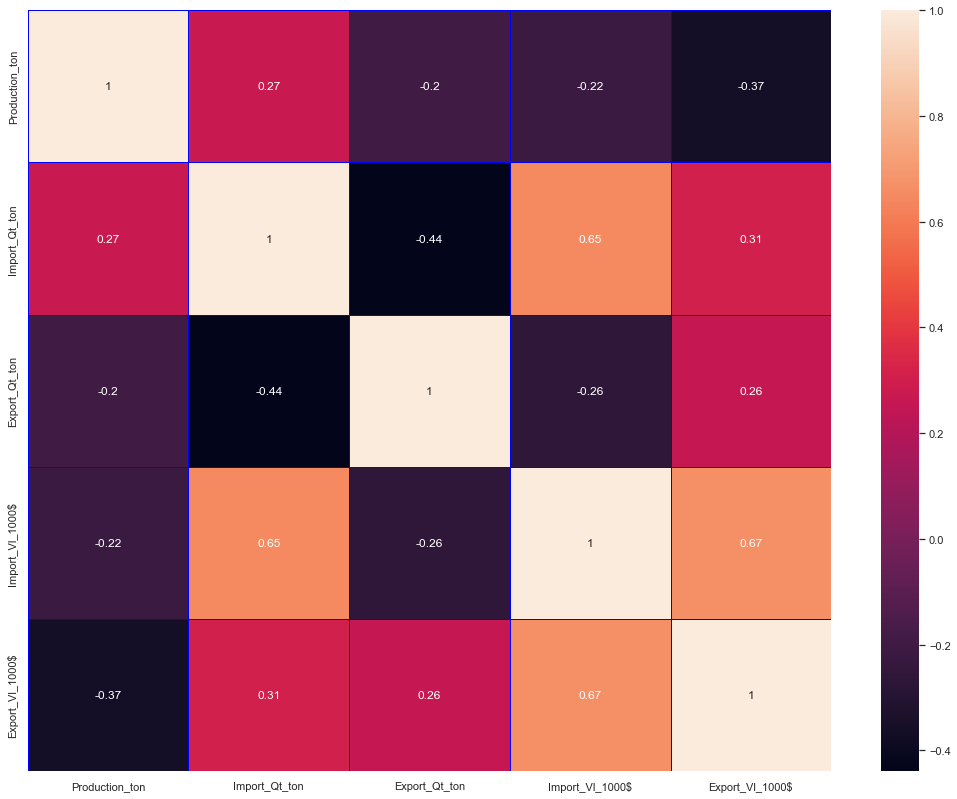

In [41]:
plt.figure(figsize=(18,14))
sns.heatmap(country.corr(),annot=True,linecolor="blue",lw=0.5)